# Exercise 8
## 2  Non-negative matrix factorization
### Setup

In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
from sklearn import decomposition
from scipy import sparse as sp
digits = load_digits ()
X = digits ["data" ]/255.
Y = digits ["target"]

### 2.1 Comparison of scikit-learn's NMF with SVD

In [2]:
def largestNIndices(a,n,axis=1):
    ind=np.unravel_index(a.flatten().argsort()[::-1],a.shape)[axis]
    return np.argsort(np.unique(ind,return_index=True)[1])[:n]

In [3]:
def plotEigVec(v):
    fig=plt.figure(figsize=(9,6))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(v[i].reshape(8,8),cmap='gray')
        plt.title(i+1)
        plt.axis('off')

In [4]:
#SVD
Xmean=np.mean(X,axis=0)
X_tilde=X-Xmean
u,s,vh=np.linalg.svd(X_tilde)
#row indices for the 6 largest values in vh
#save in SVD_mir (most important rows)
SVD_mir=largestNIndices(vh,6,1)
svdBasis=vh.T[SVD_mir]+Xmean

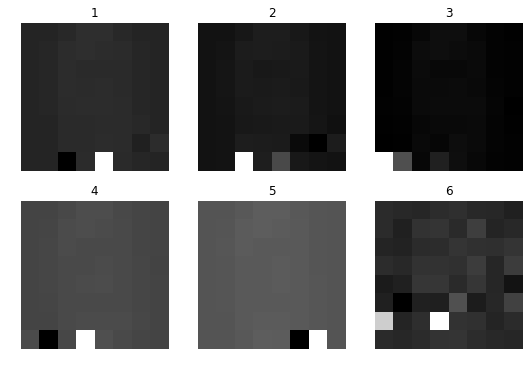

In [5]:
plotEigVec(svdBasis)

In [6]:
#sklearn's NMF
nmf=decomposition.NMF(n_components=10, init='random',random_state=0)
Z=nmf.fit_transform(X)
H=nmf.components_
NMF_mir=largestNIndices(H,6,0)

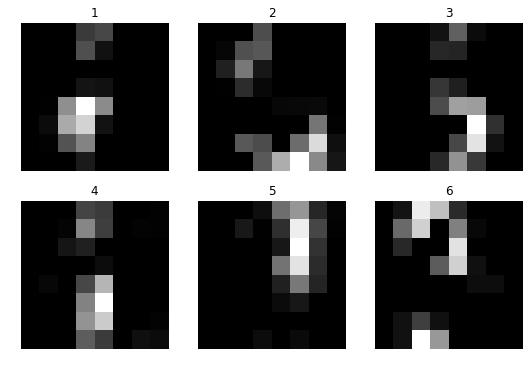

In [7]:
plotEigVec(H[NMF_mir])

### 2.2 Implementation

In [8]:
def non_negative(data,num_components,T=1000,returnLoss=False,update=False):
    X=data
    a,b=X.shape
    #initialize  H,Z:
    H_t,Z_t=np.abs(np.random.normal(size=(num_components,b))),np.abs(np.random.normal(size=(a,num_components)))
    #initialize updated H,Z
    H,Z=None,None
    #squared loss
    loss=[]
    for t in range(T):
        H=np.multiply(H_t,np.divide(Z_t.T@X,np.clip(Z_t.T@Z_t@H_t,1e-6,None)))
        Z=np.multiply(Z_t,np.divide(X@H.T,np.clip(Z_t@H@H.T,1e-6,None)))
        H_t,Z_t=H,Z
        loss.append(np.linalg.norm(X-Z_t@H_t)**2)
        if update:
            print('%i/%i'%(t+1,T),end='\r')
    return (H_t,Z_t,loss) if returnLoss else (H_t,Z_t)

In [9]:
h,z,l=non_negative(X,6,returnLoss=True)

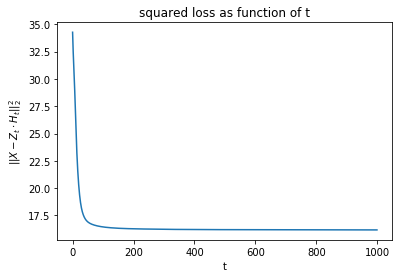

In [10]:
plt.plot(l)
plt.title('squared loss as function of t')
plt.xlabel('t')
plt.ylabel('$||X-Z_t\cdot H_t||^2_2$')
plt.show()

In [11]:
np.count_nonzero(np.gradient(l)>0)

0

That shows that the squared loss is non-increasing with $t$.

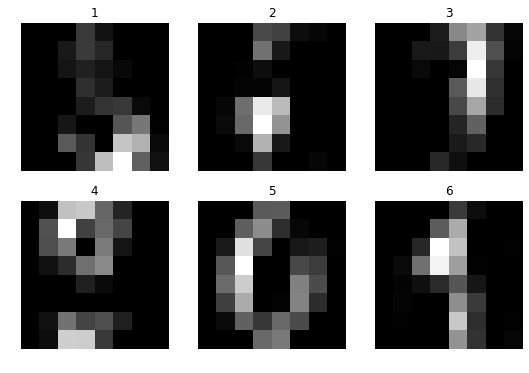

In [12]:
plotEigVec(h[largestNIndices(h,6,0)])

looks similar to the NMF result using <tt>scikit-learn</tt>

## 3 Recommender system

In [13]:
import pandas as pd # install pandas via conda
# column headers for the dataset
ratings_cols = ['user id','movie id','rating','timestamp']
movies_cols = ['movie id','movie title','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
' Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller',
'War' ,'Western']
users_cols = ['user id','age','gender','occupation','zip code']
users = pd.read_csv('ml-100k/u.user', sep ='|',names = users_cols , encoding ='latin-1')
movies = pd.read_csv('ml-100k/u.item', sep='|',names = movies_cols , encoding ='latin-1')

ratings = pd.read_csv('ml-100k/u.data', sep ='\t',names = ratings_cols , encoding ='latin-1')

# create a joint ratings dataframe for the matrix

rat_df = ratings.pivot(index ='user id',columns ='movie id', values ='rating')
fill_value = 0#rat_df.mean()
rat_df.fillna(fill_value,inplace=True)
rat_df.head()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
H,Z=non_negative(rat_df,15,update=True)

In [15]:
#percent of nonrated movies in total:
100-100*sp.coo_matrix(rat_df).nnz/np.prod(rat_df.shape)

93.69533063577546

In [16]:
100-100*sp.coo_matrix(Z@H).nnz/np.prod(rat_df.shape)

0.10869249983923623

In [36]:
reconstruction=pd.DataFrame(Z@H,columns=rat_df.columns)

In [141]:
def recommend_movies(reconstruction , user_id , movies , ratings):
    possibleRatings=reconstruction.ix[user_id]
    #find all already rated movies of this user
    ratedMovies=ratings.loc[ratings['user id']==user_id].T.ix['movie id']
    #remove those movies from the list
    movieIndices=np.delete(possibleRatings.index,ratedMovies-1) #1 indexing
    rec=reconstruction.ix[user_id][movieIndices].sort_values(ascending=False).index
    #retrun only movies with a recommendation of 2.5 or higher
    rec=np.where(possibleRatings[movieIndices]>2.5)[0]#rec[possibleRatings[movieIndices]>=2.5]
    #now return the names of all movies listed by rating
    return movies.ix[rec]

In [142]:
recommend_movies(reconstruction,1,movies,ratings)['movie title']

3            Get Shorty (1995)
12     Mighty Aphrodite (1995)
13          Postino, Il (1994)
27            Apollo 13 (1995)
29        Belle de jour (1967)
40        Billy Madison (1995)
202          Unforgiven (1992)
Name: movie title, dtype: object

In [132]:
movies['movie title'][np.where(rat_df.ix[1]>.5)[0]+1]

1                                       GoldenEye (1995)
2                                      Four Rooms (1995)
3                                      Get Shorty (1995)
4                                         Copycat (1995)
5      Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6                                  Twelve Monkeys (1995)
7                                            Babe (1995)
8                                Dead Man Walking (1995)
9                                     Richard III (1995)
10                                  Seven (Se7en) (1995)
11                            Usual Suspects, The (1995)
12                               Mighty Aphrodite (1995)
13                                    Postino, Il (1994)
14                             Mr. Holland's Opus (1995)
15                    French Twist (Gazon maudit) (1995)
16                            From Dusk Till Dawn (1996)
17                             White Balloon, The (1995)
18                             

In [172]:
ratings

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [161]:
#add our own user id
users.append(pd.DataFrame([[944,20,'M','student',55107]],columns=users_cols,dtype=object,index=[943]))

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


In [171]:
ownRating=np.zeros(1682)
ownRating[np.array([0,5])]=1
rat_df.append(pd.DataFrame([ownRating],columns=np.arange(1,1683),index=[944],dtype=np.float64))

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
movies.ix[np.arange(500)]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [159]:
pd.DataFrame([[944,20,'M','student',55107]],columns=users_cols,dtype=object,index=[943])

,user id,age,gender,occupation,zip code
943,944,20,M,student,55107
